In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import re
preferred_fonts = ['Microsoft YaHei', 'PingFang SC', 'Arial Unicode MS', 'Noto Sans CJK SC', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 路径根据你的情况替换
df_content = pd.read_json('C:/Users/17373/codepath/MeetFresh/EDA_stakeholder/data_4_4/contents_cooked.json')
df_content.head()

,note_id,content_type_video,title,desc,post_time,last_update_time,user_id,liked_count,collected_count,comment_count,share_count,tag_list,image_count,interaction_count,hot_note,extract_ts
0,67d0d605000000002903d86a,0,有没有和我一样【吃茶三千】一喝一个不吱声的,连地址都不想写了[笑哭R]\n虽然环境还不错，颜值也不错\n但我感觉自己完全拔草了\n尝了m...,2025-03-12 00:32:05,1741,576d3bde82ec3952ff40c5e1,5,2,10,3,"达拉斯网红奶茶,达拉斯奶茶,达拉斯,达拉斯生活,达拉斯美食,达拉斯周边,达拉斯探店",1,10,0,1741740908175
1,67c8960f000000002503ff5f,0,【达拉斯·玩】超治愈系手工体验！MUMU Garden,"📍301 W Parker Rd #208[话题]#, Plano, TX 75023（快乐...",2025-03-05 18:21:03,1741,576d3bde82ec3952ff40c5e1,47,23,7,37,"208,达拉斯生活,达拉斯探店,达拉斯,达拉斯吃喝玩乐,达拉斯手工,达拉斯周末,达拉斯周边,...",14,107,0,1741740908248
2,67b2c2f0000000002602e61d,0,【达拉斯·吃】米其林推荐川菜主厨空降达拉斯？,"📍2528 Old Denton Rd, Carrollton, TX 75006\n听说米...",2025-02-17 05:02:40,1739,576d3bde82ec3952ff40c5e1,85,80,38,155,"达拉斯美食,达拉斯生活,Texas,达拉斯,达拉斯周边美食,达拉斯探店,达拉斯川菜,carr...",15,320,1,1741740908264
3,67a926770000000029011c49,0,【达拉斯·吃】许留山这几碗糯唧唧绝了！,"Hui Liu Shan\n📍2540 Old Denton Rd Ste 310, Car...",2025-02-09 22:04:39,1739,576d3bde82ec3952ff40c5e1,48,20,5,15,"达拉斯,德州,达拉斯美食,德州美食,达拉斯探店,达拉斯生活,许留山,达拉斯甜品,达拉斯网红甜...",5,83,0,1741740908290
4,67a3d27600000000290360e3,0,【达拉斯·喝】Frosty Fox奶茶礼盒开箱,大过年的没想到收到一个奶茶礼盒做开箱分享！新年快乐[大笑R]\nFrosty Fox是一家从...,2025-02-05 21:04:54,1738,576d3bde82ec3952ff40c5e1,15,4,4,2,"达拉斯奶茶,达拉斯网红奶茶,达拉斯美食,德州美食,达拉斯生活,德州生活,frostyfox,...",7,21,0,1741740908312


In [31]:
# 转换时间格式
df_content['post_time'] = pd.to_datetime(df_content['post_time'])
df_content['year_month'] = df_content['post_time'].dt.to_period('M')
df_content['hour'] = df_content['post_time'].dt.hour
df_content['dayofweek'] = df_content['post_time'].dt.dayofweek

C:\Users\17373\AppData\Local\Temp\ipykernel_58820\2296100240.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_kw = df_content['title'].str.contains(kw, case=False, na=False) | df_content['desc'].str.contains(kw, case=False, na=False)


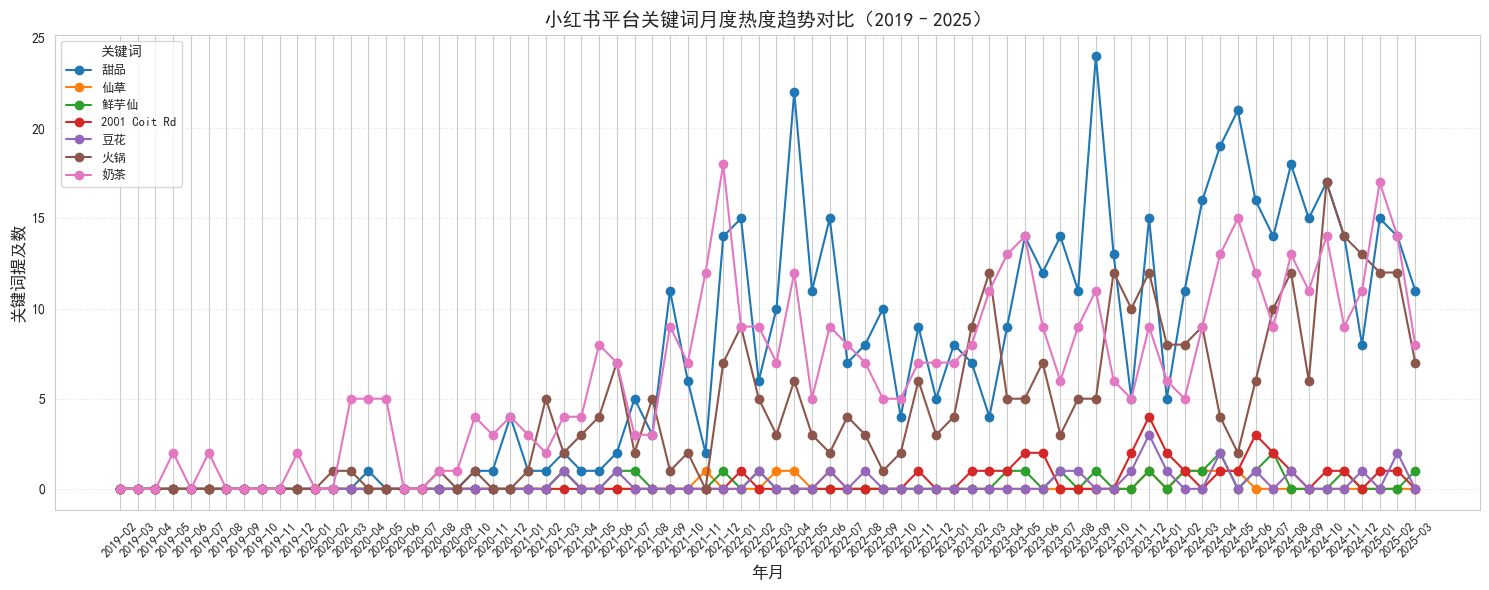

In [32]:
# Step 1: 时间格式统一并筛选 2019 之后数据
df_content['post_time'] = pd.to_datetime(df_content['post_time'], errors='coerce')
df_content = df_content[df_content['post_time'] >= '2019-02-01'].copy()
df_content['year_month'] = df_content['post_time'].dt.to_period('M').astype(str)

# Step 2: 自定义关键词列表
keywords = [
    '鲜芋仙', 'Meet Fresh', '芒果冰', '黑糖奶茶', '奶茶', '火锅', '甜品',
    '仙草', '芋圆', '豆花', 'taro', 'grass jelly', 'milk tea', 'tofu pudding',
    '蛋仔', '奶刨冰', 'milked shaved ice', '红豆汤', 'purple rice soup',
    '紫米粥', 'red bean soup', 'Park Pavillion Center', '台湾美食',
    '2001 Coit Rd', '(972) 596-6088'
]

# Step 3: 初始化趋势表
df_trend = pd.DataFrame(index=sorted(df_content['year_month'].unique()))

for kw in keywords:
    mask_kw = df_content['title'].str.contains(kw, case=False, na=False) | df_content['desc'].str.contains(kw, case=False, na=False)
    counts = df_content[mask_kw].groupby('year_month').size()
    df_trend[kw] = counts

df_trend.fillna(0, inplace=True)

# Step 4: 绘图（选取关键词展示）
plt.figure(figsize=(15, 6))
selected_keywords = ['甜品','仙草','鲜芋仙', "2001 Coit Rd", '豆花','火锅', '奶茶']

for kw in selected_keywords:
    plt.plot(df_trend.index, df_trend[kw], label=kw, marker='o')

plt.title('小红书平台关键词月度热度趋势对比（2019–2025）', fontsize=14, weight='bold')
plt.xlabel('年月', fontsize=12)
plt.ylabel('关键词提及数', fontsize=12)
plt.xticks(rotation=45, fontsize=9)
plt.yticks(fontsize=10)
plt.legend(title='关键词', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\17373\AppData\Local\Temp\ipykernel_58820\3898565666.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_content['title'].str.contains(kw, case=False, na=False) | df_content['desc'].str.contains(kw, case=False, na=False)


<Figure size 1400x600 with 0 Axes>

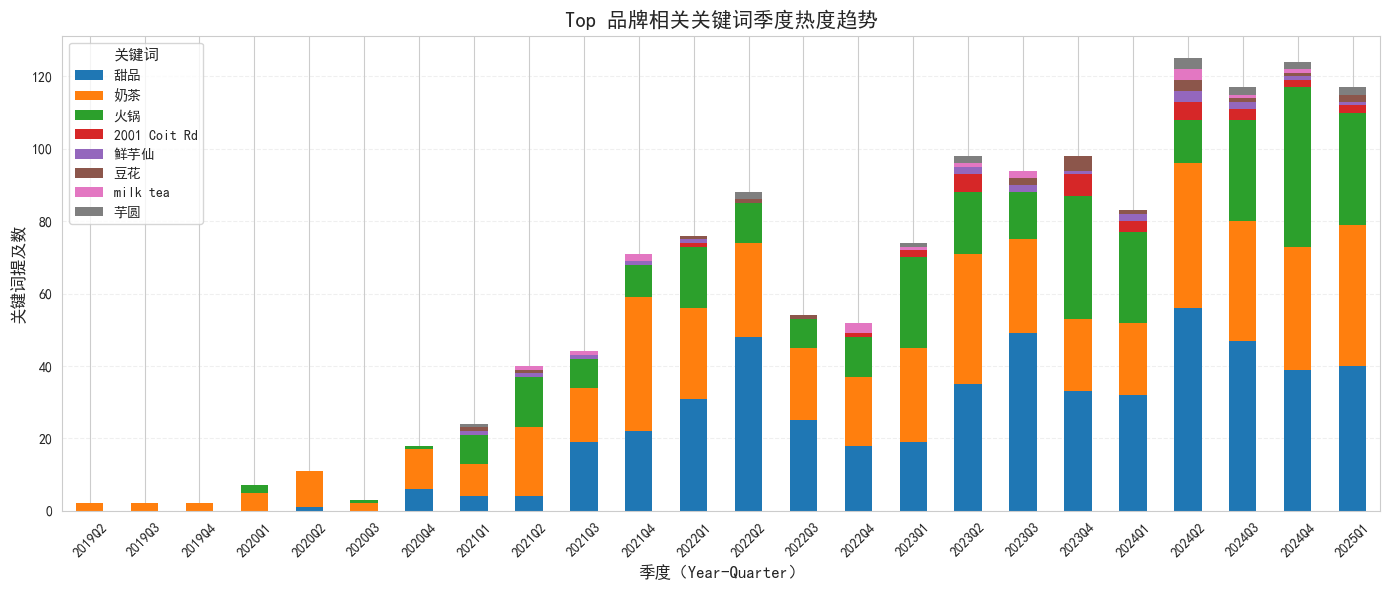

In [33]:
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']  # 可替换为 'Arial Unicode MS' 或 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

# 提取季度信息
df_content['post_time'] = pd.to_datetime(df_content['post_time'], errors='coerce')
df_content['quarter'] = df_content['post_time'].dt.to_period('Q').astype(str)

# 自定义关键词词库
keywords = [
    '鲜芋仙', 'Meet Fresh', 'Park Pavillion Center', '台湾美食', '甜品',
    '芋圆', 'taro', '仙草', 'grass jelly', '奶茶', 'milk tea', '豆花', 'tofu pudding',
    '蛋仔', '奶刨冰', 'milked shaved ice', '红豆汤', 'purple rice soup',
    '紫米粥', 'red bean soup', '2001 Coit Rd', '(972) 596-6088', '火锅', '芒果冰', '黑糖奶茶'
]

# 构造关键词-季度频率表
keyword_quarter_counts = {}
for kw in keywords:
    mask = df_content['title'].str.contains(kw, case=False, na=False) | df_content['desc'].str.contains(kw, case=False, na=False)
    df_kw = df_content[mask]
    counts = df_kw.groupby('quarter').size()
    keyword_quarter_counts[kw] = counts

df_kw_q = pd.DataFrame(keyword_quarter_counts).fillna(0).astype(int)

# 🔝 选择 Top N 高频关键词
top_n = 8
top_keywords = df_kw_q.sum().sort_values(ascending=False).head(top_n).index.tolist()
df_kw_q_top = df_kw_q[top_keywords]

# 📊 绘图
colors = sns.color_palette("tab10", n_colors=top_n)

plt.figure(figsize=(14, 6))
df_kw_q_top.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    color=colors,
    linewidth=0  # 取消边框
)

plt.title('Top 品牌相关关键词季度热度趋势', fontsize=15, weight='bold')
plt.xlabel('季度（Year-Quarter）', fontsize=12)
plt.ylabel('关键词提及数', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='关键词', fontsize=10, title_fontsize=11, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


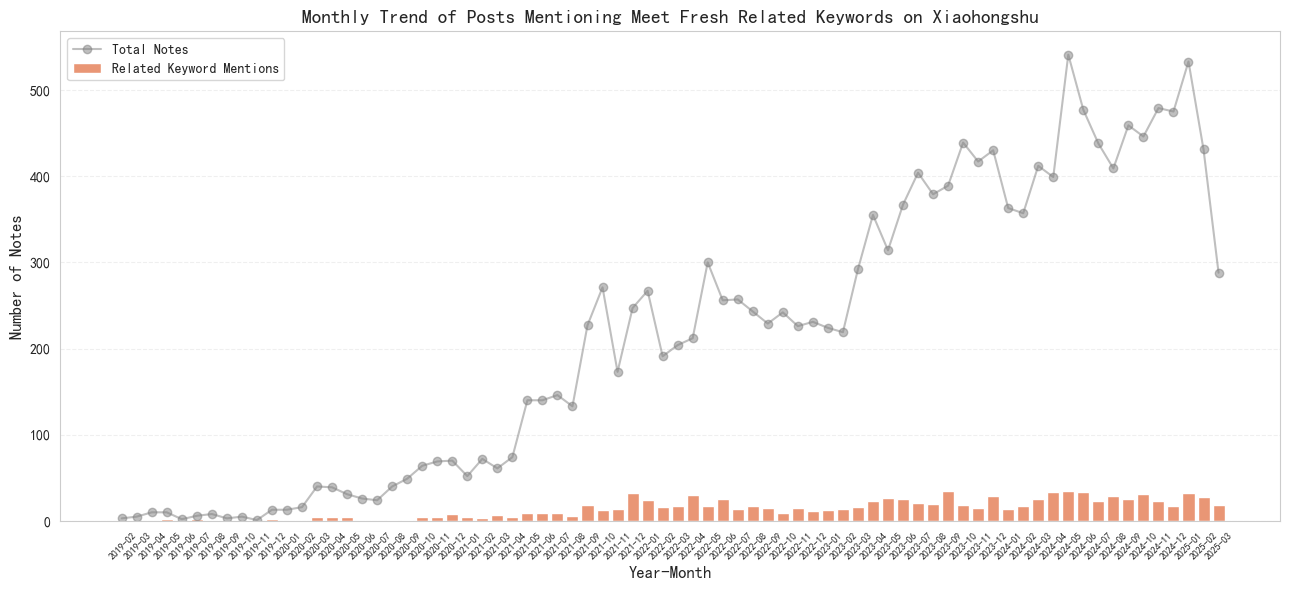

In [34]:
# Total posts per month
total_posts = df_content.groupby('year_month').size().rename('total_notes')

# ✅ Define broader list of related keywords
related_keywords = [
    '鲜芋仙', 'Meet Fresh', 'Park Pavillion Center', '台湾美食', '甜品',
    '芋圆', 'taro', '仙草', 'grass jelly', '奶茶', 'milk tea', '豆花', 'tofu pudding',
    '蛋仔', '奶刨冰', 'milked shaved ice', '红豆汤', 'purple rice soup',
    '紫米粥', 'red bean soup', '2001 Coit Rd', '(972) 596-6088',  '芒果冰', '黑糖奶茶'
]

# Combine keyword mask
mask_related = df_content['title'].fillna('') + df_content['desc'].fillna('')
mask = mask_related.apply(lambda x: any(kw.lower() in x.lower() for kw in related_keywords))
related_posts = df_content[mask]

# Related keyword mentions per month
related_counts = related_posts.groupby('year_month').size().rename('related_mentions')

# Merge and calculate ratio
df_plot = pd.concat([total_posts, related_counts], axis=1).fillna(0)
df_plot['mention_rate'] = df_plot['related_mentions'] / df_plot['total_notes']

# Plotting
plt.figure(figsize=(13, 6))
sns.barplot(x=df_plot.index, y=df_plot['related_mentions'], color='#fc8d62', label='Related Keyword Mentions')
plt.plot(df_plot.index, df_plot['total_notes'], color='gray', marker='o', linestyle='-', label='Total Notes', alpha=0.5)

plt.title('Monthly Trend of Posts Mentioning Meet Fresh Related Keywords on Xiaohongshu', fontsize=14, weight='bold')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Number of Notes', fontsize=12)
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=10)
plt.legend(title='', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\17373\AppData\Local\Temp\ipykernel_58820\1105114195.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_content['desc'].fillna('').str.contains('|'.join(terms), case=False) | \
C:\Users\17373\AppData\Local\Temp\ipykernel_58820\1105114195.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_content['title'].fillna('').str.contains('|'.join(terms), case=False)


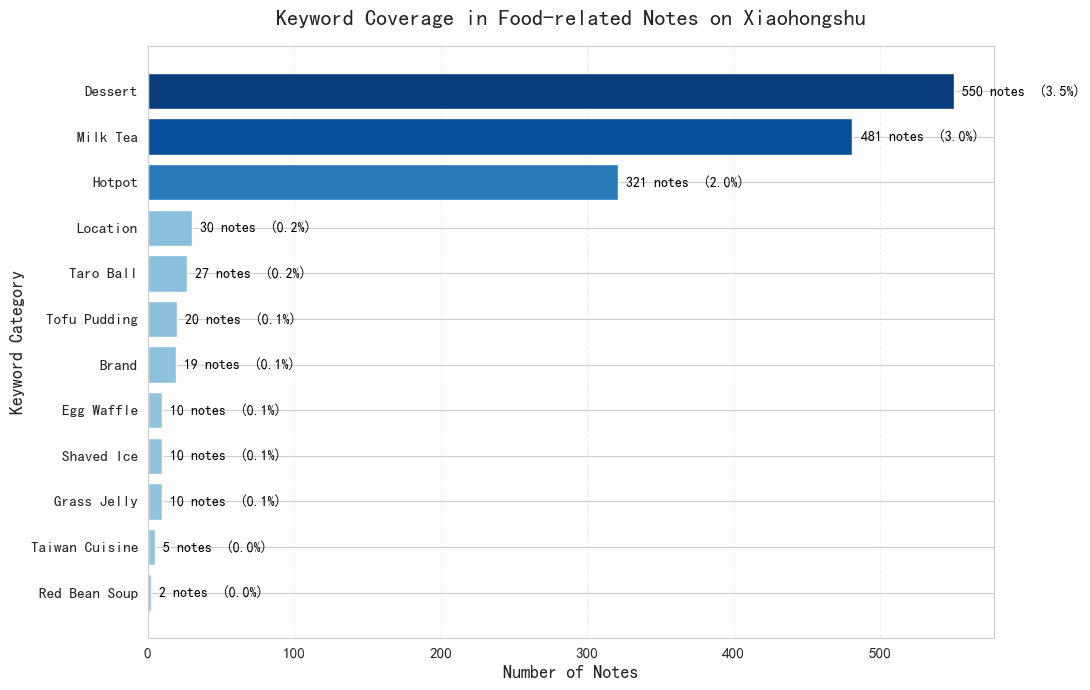

In [37]:
# ✅ 关键词词典（中英文组合）
keywords = {
    'Dessert': ['dessert', '甜品'],
    'Hotpot': ['hotpot', '火锅'],
    'Milk Tea': ['milk tea', '奶茶', '黑糖奶茶'],
    'Grass Jelly': ['grass jelly', '仙草'],
    'Taro Ball': ['taro ball', '芋圆', 'taro'],
    'Tofu Pudding': ['tofu pudding', '豆花'],
    'Red Bean Soup': ['red bean soup', '红豆汤', 'purple rice soup', '紫米粥'],
    'Shaved Ice': ['milked shaved ice', '奶刨冰', '芒果冰'],
    'Egg Waffle': ['蛋仔'],
    'Brand': ['鲜芋仙', 'Meet Fresh'],
    'Location': ['Park Pavillion Center', '2001 Coit Rd', '(972) 596-6088'],
    'Taiwan Cuisine': ['台湾美食']
}

# ✅ 统计关键词出现数量
keyword_counts = {}
for label, terms in keywords.items():
    mask = df_content['desc'].fillna('').str.contains('|'.join(terms), case=False) | \
           df_content['title'].fillna('').str.contains('|'.join(terms), case=False)
    keyword_counts[label] = mask.sum()

# ✅ 转为 DataFrame 并排序
df_kw = pd.DataFrame(list(keyword_counts.items()), columns=['Keyword', 'Note Count'])
df_kw['Coverage Rate'] = df_kw['Note Count'] / len(df_content)
df_kw = df_kw.sort_values(by='Note Count', ascending=True)

# ✅ 使用蓝色渐变（中段～深色）
norm = colors.Normalize(vmin=df_kw['Note Count'].min(), vmax=df_kw['Note Count'].max())
cmap = cm.Blues
bar_colors = [cmap(0.4 + 0.55 * norm(v)) for v in df_kw['Note Count']]

# ✅ 绘图
plt.figure(figsize=(11, 7))
bars = plt.barh(df_kw['Keyword'], df_kw['Note Count'], color=bar_colors)

# ✅ 注释：右侧展示 note 数 + 覆盖率
for i, (count, rate) in enumerate(zip(df_kw['Note Count'], df_kw['Coverage Rate'])):
    plt.text(count + max(df_kw['Note Count']) * 0.01, i,
             f"{count} notes  ({rate*100:.1f}%)",
             va='center', fontsize=10, color='black')

# ✅ 样式美化
plt.title('Keyword Coverage in Food-related Notes on Xiaohongshu', fontsize=16, weight='bold', pad=15)
plt.xlabel('Number of Notes', fontsize=13)
plt.ylabel('Keyword Category', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\17373\AppData\Local\Temp\ipykernel_58820\934272481.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


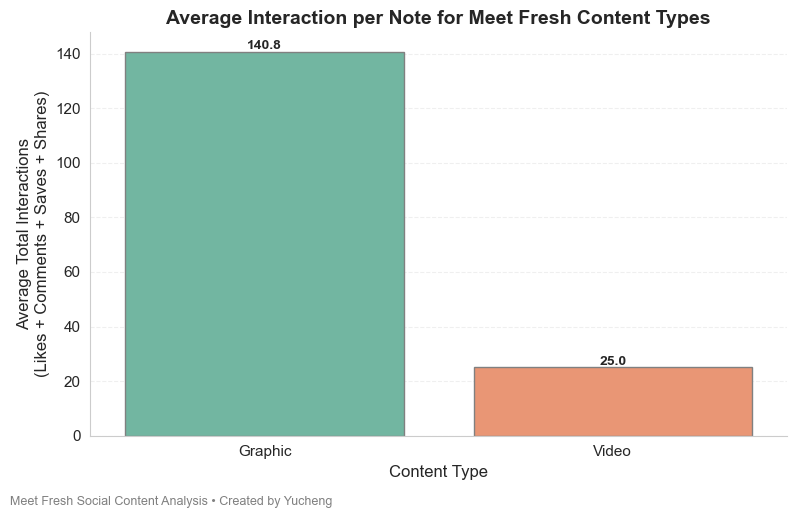

In [38]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'Arial Unicode MS', 'SimHei']  # Fallbacks
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# --- Plot: Average Interactions by Content Type ---
plt.figure(figsize=(8, 5))
bar = sns.barplot(
    data=df_summary, 
    x='content_type', 
    y='avg_interaction', 
    palette='Set2', 
    edgecolor='gray'
)

# Title and labels
plt.title('Average Interaction per Note for Meet Fresh Content Types', fontsize=14, weight='bold')
plt.xlabel('Content Type', fontsize=12)
plt.ylabel('Average Total Interactions\n(Likes + Comments + Saves + Shares)', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Annotate values on top of bars
for i, row in df_summary.iterrows():
    bar.text(
        x=i, 
        y=row['avg_interaction'] + 1, 
        s=f'{row["avg_interaction"]:.1f}', 
        ha='center', 
        fontsize=10, 
        fontweight='bold'
    )

# Remove spines and adjust layout
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

# Footer (optional)
plt.figtext(0.01, -0.02, 'Meet Fresh Social Content Analysis • Created by Yucheng', fontsize=9, color='gray')

plt.show()


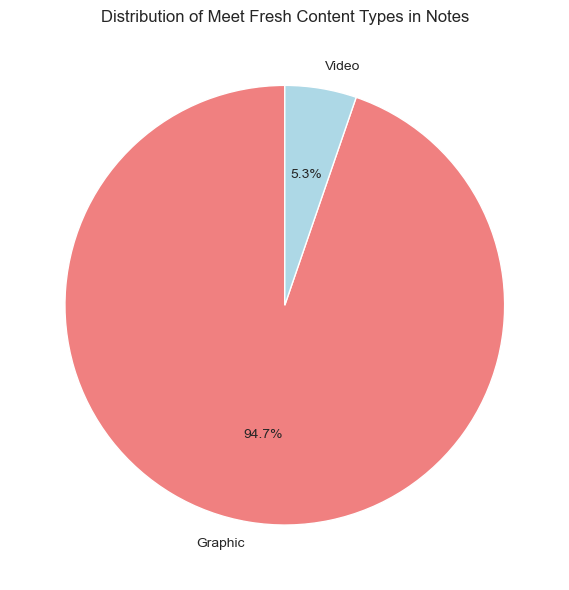

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(df_summary['note_ratio'], labels=df_summary['content_type'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
plt.title('Distribution of Meet Fresh Content Types in Notes')
plt.tight_layout()
plt.show()


In [ ]:
# 提取含"鲜芋仙"关键词的内容
mask = df_content['desc'].fillna('').str.contains('鲜芋仙|Meet\s?Fresh', case=False) | \
        df_content['title'].fillna('').str.contains('鲜芋仙|Meet\s?Fresh', case=False)
df_mf = df_content[mask].copy()

# 时间字段转换（如果没做过）
df_mf['post_time'] = pd.to_datetime(df_mf['post_time'])

# 添加时间特征
df_mf['hour'] = df_mf['post_time'].dt.hour
df_mf['weekday'] = df_mf['post_time'].dt.dayofweek  # 0=Mon, 6=Sun
day_map = {0:'Mon 周一', 1:'Tue 周二', 2:'Wed 周三', 3:'Thu 周四', 4:'Fri 周五', 5:'Sat 周六', 6:'Sun 周日'}
df_mf['weekday_label'] = df_mf['weekday'].map(day_map)


<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\17373\AppData\Local\Temp\ipykernel_58820\4011506007.py:10: SyntaxWarning: invalid escape sequence '\s'
  mask = df_content['desc'].fillna('').str.contains('鲜芋仙|Meet\s?Fresh', case=False) | \
C:\Users\17373\AppData\Local\Temp\ipykernel_58820\4011506007.py:11: SyntaxWarning: invalid escape sequence '\s'
  df_content['title'].fillna('').str.contains('鲜芋仙|Meet\s?Fresh', case=False)


C:\Users\17373\AppData\Local\Temp\ipykernel_58820\1414480676.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df_mf, palette='Blues')


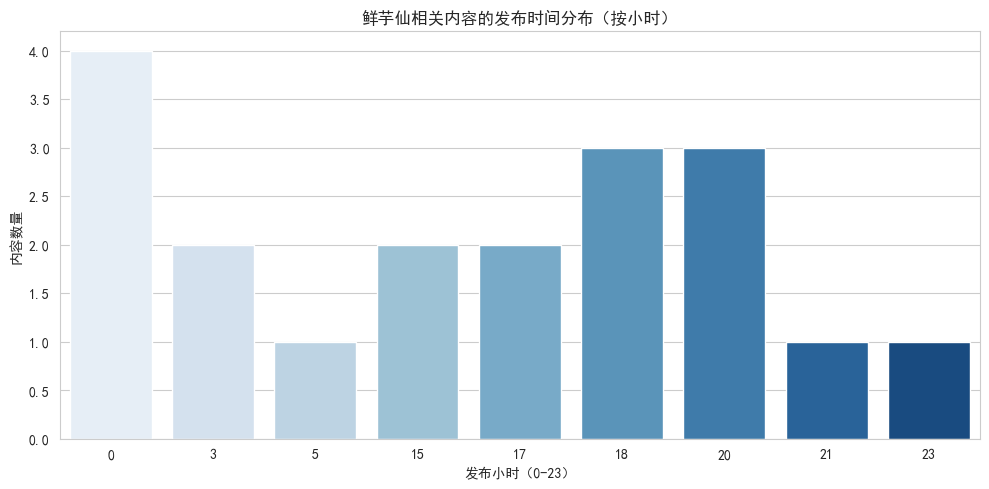

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='hour', data=df_mf, palette='Blues')
plt.title('鲜芋仙相关内容的发布时间分布（按小时）')
plt.xlabel('发布小时（0-23）')
plt.ylabel('内容数量')
plt.tight_layout()
plt.show()


C:\Users\17373\AppData\Local\Temp\ipykernel_58820\94636911.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='weekday_label', data=df_mf, order=order, palette='Set3')


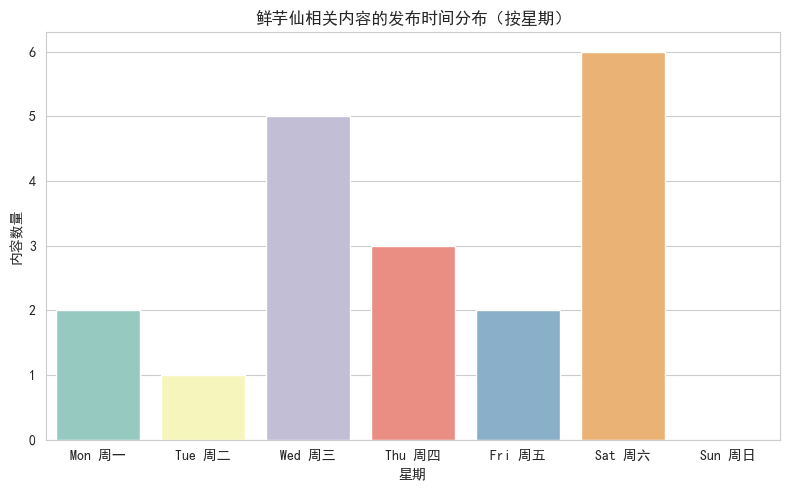

In [ ]:
plt.figure(figsize=(8, 5))
order = ['Mon 周一', 'Tue 周二', 'Wed 周三', 'Thu 周四', 'Fri 周五', 'Sat 周六', 'Sun 周日']
sns.countplot(x='weekday_label', data=df_mf, order=order, palette='Set3')
plt.title('鲜芋仙相关内容的发布时间分布（按星期）')
plt.xlabel('星期')
plt.ylabel('内容数量')
plt.tight_layout()
plt.show()
